In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import time
# import subprocess
import random

In [2]:
%matplotlib inline

## Utils

In [3]:
def alter_coord(action, position, g_coord, dx=0.1, change_nodes=[2,3,5,7]):
        
    if action==0:
        g_coord[int(2*change_nodes[position])]+=dx
    elif action==1:
        g_coord[int(2*change_nodes[position])]-=dx
    elif action==2:
        g_coord[int(2*change_nodes[position])]+=0
             
    return g_coord

In [4]:
# this function must be tailored to different FE models
def observe(position, coord,l1,l2, displ):    
    return position, coord[4]/l2, coord[6]/l1, coord[10]/l1, coord[14]/l2, displ[9]

## Finite Element Model of the Plane Truss structure

In [5]:
def PlaneTrussElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [6]:
def PlaneTrussElementStiffness(E,A,L,theta):
    pi=3.14159265
    x = theta*pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.array([[C*C, C*S, -C*C, -C*S],[C*S, S*S, -C*S, -S*S],
                           [-C*C, -C*S, C*C, C*S],[-C*S, -S*S, C*S, S*S]]) 

In [7]:
def PlaneTrussAssemble(K,k,i,j):
    # K - np.array
    # k - np.array
    K[2*i,2*i] = K[2*i,2*i] + k[0,0]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[0,1] 
    K[2*i,2*j] = K[2*i,2*j] + k[0,2] 
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[0,3]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[1,0]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[1,1] 
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[1,2] 
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[1,3] 
    K[2*j,2*i] = K[2*j,2*i] + k[2,0] 
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[2,1]
    K[2*j,2*j] = K[2*j,2*j] + k[2,2]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[2,3] 
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[3,0] 
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[3,1]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[3,2] 
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[3,3]
    
    return K   

In [8]:
def PlaneTrussElementForce(E,A,L,theta,u):
    pi=3.14159265
    x = theta* pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.dot(np.array([-C, -S, C, S]),u)

In [9]:
def PlaneTrussElementStress(E,L,theta,u):
    pi=3.14159265
    x = theta * pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E/L*np.dot(np.array([-C, -S, C, S]),u)

In [10]:
def FEA_u(coord, elcon, bc_u_elim, f_after_u_elim, A=1, E=2e5):
    K=np.zeros(shape=(2*np.max(elcon)+2,2*np.max(elcon)+2))
    pi=3.14159265
    for el in elcon:
        L=PlaneTrussElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/pi
        k=PlaneTrussElementStiffness(E,A,L,theta)
        K=PlaneTrussAssemble(K,k,el[0],el[1])
    K=np.delete(K,bc_u_elim,0)
    K=np.delete(K,bc_u_elim,1)
    
    
    d=np.dot(np.linalg.inv(K),f_after_u_elim)

        
    u=np.zeros(shape=(2*len(coord)))

    j=0
    for i in range(len(u)):
        if i not in bc_u_elim:
            u[i]=d[j]
            j+=1
            if j>len(d)-1:
                break
    return u

## Neural Network Policy - Policy Gradients

In [11]:
# Details of model can be found in the book:
# Hands-On Machine Learning with Scikit-Learn & TensorFlow. Aurйlien Gйron

In [12]:
# the NN architecture must be tailored to different FE models

In [13]:
n_inputs = 6 
n_hidden = 50 
n_outputs = 3 
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.001

# Build the neural network
X_ = tf.placeholder(tf.float64, shape=[None, n_inputs], name="X_")
hidden = fully_connected(X_, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
hidden1 = fully_connected(hidden, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
logits = fully_connected(hidden1, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.softmax(logits, name="Y_proba")

# Select a random action based on the estimated probabilities
action = tf.multinomial(tf.log(outputs), num_samples=1,output_dtype=tf.int32)

y=tf.reshape(tf.one_hot(action,depth=3,dtype=tf.float64),[3,1])
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=tf.transpose(logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float64, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
def discount_rewards(rewards, discount_rate=0.97):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [15]:
def discount_and_normalize_rewards(all_rewards, discount_rate=0.97):
    all_discounted_rewards = [discount_rewards(rewards) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [16]:
# this function must be tailored to different FE models

def reward_(obs_,obs):   
    if abs(obs_[5])>abs(obs[5]):  
        return 1
    else:
        return 0


In [17]:
# the training code must be tailored to different FE models

In [18]:
n_iterations =101 #250 # number of training iterations
n_max_steps = 500 #1000 # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 5 # save the model every 10 training iterations


with tf.Session() as sess:
    start=time.time()
    init.run() 
    
#     saver.restore(sess, tf.train.latest_checkpoint("./policy3/"))    
#     tf.get_default_graph()
    
    for iteration in range(n_iterations):
               
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
             
        for game in range(n_games_per_update):
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            
            pst=random.randint(0,3)
            g_coord = alter_coord(2, pst, np.array([0.0,0.0,2.0,3.0,2.0,0.0,5.0,3.0,7.0,0.0,9.0,3.0,12.0,3.0,12.0,0.0,14.0,0.0]),
                                          dx=0.1, change_nodes=[2,3,5,7])
            
            
            displ = FEA_u(g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_u_elim=[0,1,16,17],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                                                    A=1, E=2e5)
            
            obs=observe(pst, g_coord, 10, 14, displ)
            
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X_: np.array(obs).reshape(1,n_inputs)}) 
                obs_=obs        
                g_coord = alter_coord(action_val[0][0], pst, g_coord,
                                          dx=0.1, change_nodes=[2,3,5,7])
                
                pst=random.randint(0,3)
                
                if g_coord[4]<g_coord[0]+0.2 or g_coord[4]>g_coord[8]-0.2:
                    break
                
                if g_coord[6]<g_coord[2]+0.2 or g_coord[6]>g_coord[12]-0.2:
                    break
                    
                if g_coord[10]<g_coord[2]+0.2 or g_coord[10]>g_coord[12]-0.2:
                    break
                    
                if g_coord[14]<g_coord[8]+0.2 or g_coord[14]>g_coord[16]-0.2:
                    break    
                    
                displ = FEA_u(g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_u_elim=[0,1,16,17],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                                                    A=1, E=2e5)
                obs=observe(pst,g_coord,10,14,displ)               
                reward=reward_(obs_,obs)
                
                current_rewards.append(reward)
                current_gradients.append(gradients_val)

            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

    
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards)
        
        
        
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index] 
                                      for game_index, rewards in enumerate(all_rewards)
                                      for step, reward in enumerate(rewards)],axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        
        
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % save_iterations == 0:
#             print("Saving {} iteration".format(iteration))
            print('Time taken for {} epoch {} sec\n'.format(iteration, time.time() - start))
            saver.save(sess, "./policy3/pinjointed3.ckpt")

# end=time.time()            

Time taken for 0 epoch 6.96134090423584 sec

Time taken for 5 epoch 75.40877914428711 sec

Time taken for 10 epoch 157.29700994491577 sec

Time taken for 15 epoch 226.1288902759552 sec

Time taken for 20 epoch 339.8439302444458 sec

Time taken for 25 epoch 463.75181007385254 sec

Time taken for 30 epoch 595.1809000968933 sec

Time taken for 35 epoch 707.4287302494049 sec

Time taken for 40 epoch 808.5557150840759 sec

Time taken for 45 epoch 920.1895999908447 sec

Time taken for 50 epoch 1020.6105082035065 sec

Time taken for 55 epoch 1107.6084699630737 sec

Time taken for 60 epoch 1199.2502131462097 sec

Time taken for 65 epoch 1305.845782995224 sec

Time taken for 70 epoch 1405.3403949737549 sec

Time taken for 75 epoch 1514.0756249427795 sec

Time taken for 80 epoch 1626.8955211639404 sec

Time taken for 85 epoch 1712.7007241249084 sec

Time taken for 90 epoch 1805.482922077179 sec

Time taken for 95 epoch 1885.1180002689362 sec

Time taken for 100 epoch 1970.1715190410614 sec



In [19]:
# print(end-start)

## AI designing the bridge

In [29]:
def predict(l1,l2,coord):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./policy3/pinjointed3.ckpt.meta')
        saver.restore(sess, "./policy3/pinjointed3.ckpt") 

        graph = tf.get_default_graph()
        outputs = graph.get_tensor_by_name("Y_proba:0") 
        X_ = graph.get_tensor_by_name("X_:0") 
                
        pst=random.randint(0,3)
        
        
        g_coord = alter_coord(2, pst, coord, dx=0.1, change_nodes=[2,3,5,7])
            
        displ = FEA_u(g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_u_elim=[0,1,16,17],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                                                    A=1, E=2e5)
            
        obs=observe(pst, g_coord, 10, 14, displ)       
        
        
        for step in range(50):
            action_val= sess.run([outputs],feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
            action_val=np.log(action_val)
            
            g_coord = alter_coord(np.argmax(action_val), pst, g_coord, dx=0.1, change_nodes=[2,3,5,7])
            
            
        
            pst=random.randint(0,3)
            
            if g_coord[4]<g_coord[0]+0.2 or g_coord[4]>g_coord[8]-0.2:
                break

            if g_coord[6]<g_coord[2]+0.2 or g_coord[6]>g_coord[12]-0.2:
                break

            if g_coord[10]<g_coord[2]+0.2 or g_coord[10]>g_coord[12]-0.2:
                break

            if g_coord[14]<g_coord[8]+0.2 or g_coord[14]>g_coord[16]-0.2:
                break    

            displ = FEA_u(g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_u_elim=[0,1,16,17],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                                                    A=1, E=2e5)
            
            obs=observe(pst, g_coord, 10, 14, displ)
        
        return obs,g_coord        

In [30]:
obs, g_coord = predict(10,14,np.array([0.0,0.0,2.0,3.0,2.0,0.0,5.0,3.0,7.0,0.0,9.0,3.0,12.0,3.0,12.0,0.0,14.0,0.0]))

INFO:tensorflow:Restoring parameters from ./policy3/pinjointed3.ckpt


In [31]:
obs[-1]

-0.0008387753119369001

In [32]:
# Benchmark from initial design:
-0.8888E-03

-0.0008888

In [33]:
g_coord

array([ 0. ,  0. ,  2. ,  3. ,  3.5,  0. ,  6.5,  3. ,  7. ,  0. ,  8.3,
        3. , 12. ,  3. , 11.1,  0. , 14. ,  0. ])

In [34]:
import matplotlib.pyplot as plt

In [35]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],[coord[item[0]][1],coord[item[1]][1]],color=color)
       
    plt.show()    

### Initial Design 

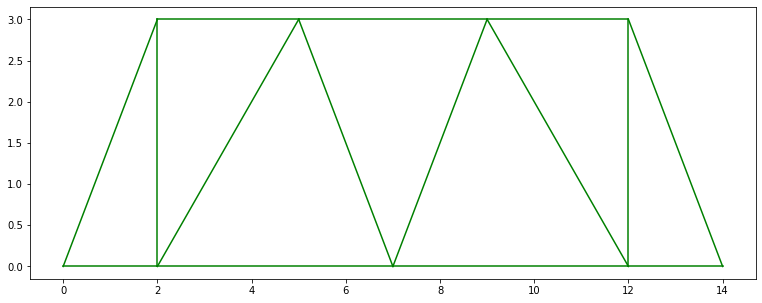

In [36]:
draw(np.array([0.0,0.0,2.0,3.0,2.0,0.0,5.0,3.0,7.0,0.0,9.0,3.0,12.0,3.0,12.0,0.0,14.0,0.0]),color="green",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

### Design by AI

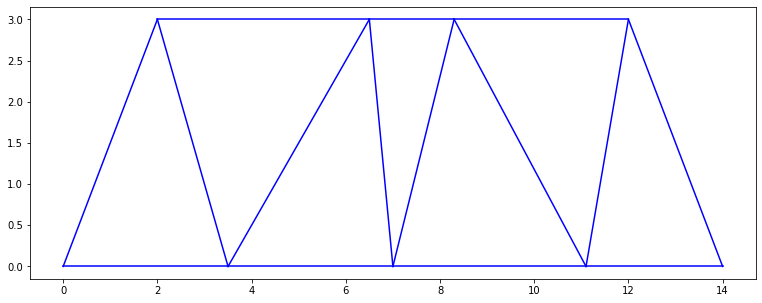

In [37]:
draw(g_coord,color="blue",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))